In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib import rc
import seaborn as sns
plt.rcParams['ps.useafm'] = True
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

import pandas as pd
import time
import shutil
import argparse
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('/DATA/lucaa/software/CLoNe')

from clone import CLoNe
from plot import plot_clusters
from structural_utils import load_md_args, show_cluster_info

import mdtraj
import pyemma

print(__doc__)
start = time.time()


def calculate_pca(topo, traj, main_folder, syst, at_sel, n_pca ):
    # Load trajectory
    topology = mdtraj.load(topo).topology
    struct_ens = mdtraj.load(traj, top=topo)

    # Create result folder based on dataset nam\e
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    out_idx =  1
    output_folder = main_folder+"/%s_%i/"
    while os.path.exists(output_folder%(syst, out_idx)):
        out_idx += 1
    output_folder = output_folder%(syst, out_idx)
    os.makedirs(output_folder)
    

    selection = struct_ens.topology.select(at_sel)
    coords = struct_ens.xyz[:, selection]
    coords = coords.reshape(coords.shape[0], coords.shape[1] * coords.shape[2])
    headers = ["C%i"%x for x in range(len(coords[0]))]  # general headers

    # Principal component analysis
    original_coords = coords.copy()
    pca_obj = PCA(n_components=n_pca)
    reddim_coords = pca_obj.fit_transform(coords)
    eigenvalues = pca_obj.explained_variance_ratio_
    ratio = np.sum(eigenvalues[:n_pca])
    pca_headers = ["PC%i (%.2f)"%(x + 1, eigenvalues[x]) for x in range(n_pca)]
    
    print("> PCA: %i => %i dimension(s) with eigenval.: %s"%(len(headers), n_pca, str(eigenvalues)))
    print("sum of Variance: %s"%(np.sum(eigenvalues)))
    with open("%sPCA_coords.txt"%output_folder, "w") as f:
        for x in range(n_pca):
            f.write("PC%i(%.2f) "%(x + 1, eigenvalues[x]))
        f.write("\n")
        for el in reddim_coords:
            for n in el:
                f.write("%f "%n)
            f.write("\n")  
    return pca_obj, reddim_coords, original_coords


def calc_magn_vector(pc):
    final_length = int(len(pc)/3)
    pc_magn = np.empty(final_length)
    
    for i in range(final_length):
        pc_magn[i] = np.sqrt(pc[i*3]**2+pc[i*3+1]**2+pc[i*3+2]**2)
    
    return pc_magn


def save_pc_bfact(init_padding, length_pc, final_padding, structure, pc_component, outpdb):

    pc_elongated = np.concatenate((np.zeros(init_padding),calc_magn_vector(pc_component),np.zeros(final_padding)))
    system_length_res = len([residue for residue in structure.topology.residues])
    system_length_atoms = len([ atom for atom in structure.topology.atoms])

    syst_bfact=np.zeros(system_length_atoms)
    index=0
    for resid in range(system_length_res):
        res_len = len(structure.topology.select('resid '+str(resid)))
        res_bfact= res_len
        syst_bfact[index:index+res_len] = pc_elongated[resid]
        index += res_len

    structure[0].save_pdb(outpdb, bfactors=syst_bfact*100)
    
# Check convercence PC
def calculate_pca_convergence(topo, traj, main_folder, syst, at_sel, n_pca, nframes, nsim ):
    # Load trajectory
    topology = mdtraj.load(topo).topology
    struct_ens = mdtraj.load(traj, top=topo)

    # Create result folder based on dataset nam\e
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    out_idx =  1
    output_folder = main_folder+"/%s_%i/"
    while os.path.exists(output_folder%(syst, out_idx)):
        out_idx += 1
    output_folder = output_folder%(syst, out_idx)
    os.makedirs(output_folder)
    
    selection = struct_ens.topology.select(at_sel)
    coords = struct_ens.xyz[:, selection]
    coords = coords.reshape(coords.shape[0], coords.shape[1] * coords.shape[2])
    headers = ["C%i"%x for x in range(len(coords[0]))]  # general headers
    
    frameslist = np.multiply(np.arange(1,nsim+1),nframes)
    original_coords = coords.copy()
    pcas_list = []
    reddim_coords_list = []
    print(np.shape(coords))
    # Principal component analysis
    for section in frameslist:
        pca_obj = PCA(n_components=n_pca)
        
        reddim_coords = pca_obj.fit_transform(coords[0:section])
        pcas_list.append(pca_obj)
        #eigenvalues = pca_obj.explained_variance_ratio_
        #ratio = np.sum(eigenvalues[:n_pca])
        #pca_headers = ["PC%i (%.2f)"%(x + 1, eigenvalues[x]) for x in range(n_pca)]
    
        #print("> PCA: %i => %i dimension(s) with eigenval.: %s"%(len(headers), n_pca, str(eigenvalues)))
        #print("sum of Variance: %s"%(np.sum(eigenvalues)))
  
    return pcas_list

Automatically created module for IPython interactive environment


In [2]:
# PARAMETERS SETUP

# Clustering parameters 
pdc=8  # neighbour search during clusterint
n_resize=4 
filt=0.1 
verbose=False
n_pca=10 # number of PC to include in calculations 
n_bins= 160  # number of bins for PC hist
# Simulations and topology 
trj_apo='apo/trjcat_md_ttpa_apo_replica1to6_center_pbcmol_fit_rot_trans_CA_after10ns_every10thframe.xtc'   # apo traj
trj_holo='holo_alpha_tocopherol/holo_protonly.xtc'# holo traj
trj_tot='apoholo_tot.xtc'   # concatenated total traj

topo_apo='apo/apo.gro'  # pdb or gro of apo

# Selection for PCA calculation (see mdtraj syntax)
at_sel="name CA and residue 88 to 253"  # try to exclude end loops or regions that move but are not interesting (hides the true PC)
n_res=165   # number of residues (still manual insertion, i know...)
feat="None"
resmin=88
resmax=253
output_folder = "results"

apo_name="apo"
holo_name="holo"
tot_name="tot"

In [3]:
# make results folder 
try:
    os.mkdir(output_folder)
except FileExistsError:
    pass
# make images folder 
try:
    os.mkdir(output_folder+'/IMAGES/')
except FileExistsError:
    pass
# Calculate PCA
pca_apo, red_dim_coords_apo, orig_coords_apo = calculate_pca(topo_apo, trj_apo, output_folder, apo_name, at_sel, n_pca)
pca_holo, red_dim_coords_holo, orig_coords_holo = calculate_pca(topo_apo, trj_holo, output_folder, holo_name, at_sel, n_pca)
pca_tot, red_dim_coords_tot, orig_coords_tot = calculate_pca(topo_apo, trj_tot, output_folder, tot_name, at_sel, n_pca)


> PCA: 498 => 10 dimension(s) with eigenval.: [0.20176926 0.08724689 0.07117479 0.05915743 0.0454983  0.03677513
 0.02909794 0.02580531 0.02186565 0.02070591]
sum of Variance: 0.59909666
> PCA: 498 => 10 dimension(s) with eigenval.: [0.15064627 0.1028734  0.07037895 0.05479676 0.04152559 0.03170445
 0.02956954 0.02658308 0.02353461 0.02123397]
sum of Variance: 0.5528466
> PCA: 498 => 10 dimension(s) with eigenval.: [0.26960126 0.07808146 0.0732134  0.06117446 0.0419452  0.02982674
 0.02588342 0.02235243 0.01817159 0.01789125]
sum of Variance: 0.6381412


In [4]:
index_apo_end=np.shape(red_dim_coords_apo)[0]
index_tot_end=np.shape(red_dim_coords_tot)[0]

# Figures PC and histograms checking that all pc apo, holo and tot are the similar 

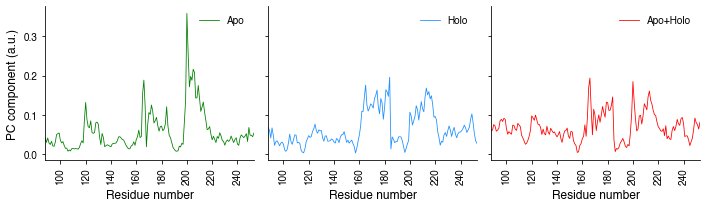

In [5]:
fig, ax = plt.subplots(1,3, figsize=(10,3), sharey=True, sharex=True)
tick_spacing = 20
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
ax[2].tick_params(axis='x', rotation=90)

ax[0].set_xlim(resmin,resmax)
ax[0].plot(np.arange(resmin, resmax+1),calc_magn_vector(pca_apo.components_[0]), linewidth=0.8, color='green')
ax[1].plot(np.arange(resmin, resmax+1),calc_magn_vector(pca_holo.components_[0]), linewidth=0.8, color='dodgerblue')
ax[2].plot(np.arange(resmin, resmax+1),calc_magn_vector(pca_tot.components_[0]), linewidth=0.8, color='red')

sns.despine()

ax[0].legend(['Apo'], frameon=False)
ax[1].legend(['Holo'], frameon=False)
ax[2].legend(['Apo+Holo'], frameon=False)

ax[0].set_xlabel("Residue number", fontsize=12, labelpad=5)
ax[1].set_xlabel("Residue number", fontsize=12, labelpad=5)
ax[2].set_xlabel("Residue number", fontsize=12, labelpad=5)
ax[0].set_ylabel("PC component (a.u.)", fontsize=12, labelpad=5)
fig.tight_layout()

fig.savefig(output_folder+'/IMAGES/comparison_pc_apo_holo_tot.pdf')

plt.show()

/DATA/lucaa/software/anaconda3/envs/cloneenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


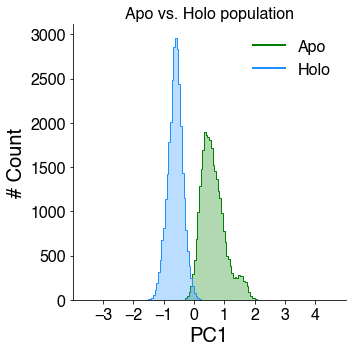

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

min_pc = -4
max_pc = 5

sns.despine()
ax.set_xlim([min_pc,max_pc])
ax.set_xticks([-3,-2,-1,0,1,2,3,4])
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.set_xlabel("PC1", fontsize=20)
ax.set_ylabel("# Count", fontsize=20)

ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

legend_elements = [Line2D([0], [0], color='green', lw=2, label='Apo'),Line2D([0], [0], color='dodgerblue', lw=2, label='Holo')]
ax.legend(['Apo','Holo'], frameon=False, fontsize=16, handles = legend_elements)
ax.set_title("Apo vs. Holo population", fontsize=16)

fig.tight_layout()
fig.savefig(output_folder+'/IMAGES/histograms_pc.pdf')
plt.show()

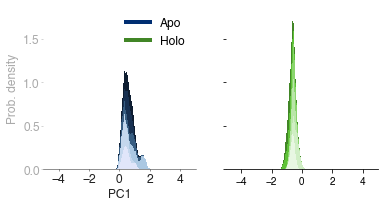

In [5]:
new_data = (red_dim_coords_tot[0:29400,0].reshape(6,4900))
new_data_holo = (red_dim_coords_tot[29400:58800,0].reshape(6,4900))

fig, ax1 = plt.subplots(1, 2, figsize=(6,3), sharex=True, sharey=True )
color_list = np.array(['#E1E6FA','#C4D7ED','#ABC8E2','#375D81','#183152','#0e1d31'])
color_list2 = np.array(['#e8f7e2','#d0eec5','#b9e6a8','#8ad56d','#5ec137','#418626'])
color_list3=np.array(['#ffc0c3','#ffa1a5','#ff8186','#ff6268','#ff424a','#ff222c',
                      '#ff030e','#e3000a','#c30008','#a30007','#840006','#650004'])
color_list4=np.array(['#def3d5','#cdedc1','#bce7ac','#ace197','#9bdb82','#8ad56d',
                      '#7acf58','#69c944','#5bbc36','#51a730','#47932a','#3d7e24'])
color_list5=np.array(['#c2dbff','#a3c9ff','#85b7ff','#67a5ff','#4893ff','#2a81ff',
                      '#0b6fff','#0060ec','#0054cd','#0047af','#003b90','#002e72'])

min_pc = -5
max_pc = 5
axcolor = '#222222'
axcolor2 = '#AAAAAA'
hfont = {'fontname':'Helvetica'}

sns.despine(left=True)

#PLOT 1 
ax1[0].set_xlim([min_pc,max_pc])
#ax1[0].set_ylim([0,1.5])
ax1[0].set_xticks([-4,-2,0,2,4])
#ax1[0].set_yticks([0,0.5, 1,1.5])
ax1[0].set_xlabel("PC1", fontsize=12, labelpad=3)
ax1[0].set_ylabel("Prob. density", fontsize=12)
ax1[0].tick_params(axis = 'both', which = 'major', labelsize =12, pad=1.5, length=2)
ax1[0].tick_params(width=0.5)
# change all spines
for axis in ['top','bottom','left','right']:
    ax1[0].spines[axis].set_linewidth(0.5)
# axes colors
ax1[0].xaxis.label.set_color(axcolor)
ax1[0].yaxis.label.set_color(axcolor2)         
ax1[0].tick_params(axis='x', colors=axcolor)    
ax1[0].tick_params(axis='y', colors=axcolor2)  
ax1[0].spines['left'].set_color(axcolor2)
ax1[0].spines['bottom'].set_color(axcolor)  

ax1[0].hist(new_data[0:6].T, range=(min_pc, max_pc), bins=n_bins, histtype="bar", stacked=True, zorder=-1, density=True, linewidth=0.2, color=color_list)
ax1[1].hist(new_data_holo[0:6].T, range=(min_pc, max_pc), bins=n_bins, histtype="bar", stacked=True, zorder=-1, density=True, linewidth=0.2, color=color_list2)

#ax1.hist(red_dim_coords_apo[:,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.3, density=True, linewidth=0.2)
custom_lines = [Line2D([0], [0], color='#002e72', lw=4),
                Line2D([0], [0], color='#418626', lw=4)]
ax1[0].legend(custom_lines, ['Apo', 'Holo'], frameon=False, fontsize=12)

#plt.show()
fig.savefig(output_folder+'/IMAGES/hist_convergence.png', dpi=600, bbox_inches='tight')

In [6]:
nframes=4900
nsim=12
pc_list_conv = calculate_pca_convergence(topo_apo, trj_tot, output_folder, tot_name, at_sel, n_pca, nframes, nsim)
product=[0]*12
for i in range(12):
    product[i] = np.dot(pc_list_conv[i].components_[0],pc_list_conv[5].components_[0])
    
print(product)

(58802, 498)
[0.88083625, 0.80874187, 0.987085, 0.9942512, 0.9966973, 1.0, 0.8515578, 0.7468563, 0.72105265, 0.6867307, 0.6684388, 0.6490401]


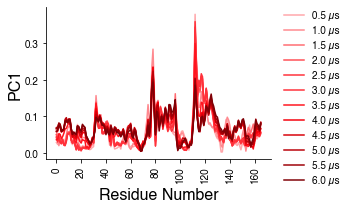

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
tick_spacing = 20
sns.despine()
color_list = ['#ffa7ab','#ff898f','#ff6c72','#ff4f56','#ff313a','#ff313a','#ff141e','#f5000b','#d80009','#bb0008','#9d0007','#800006','#620004']
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis='x', rotation=90)
#ax1.set_xlim(resmin,resmax)
ax1.set_ylabel("PC1", fontsize=16, labelpad=3)
ax1.set_xlabel("Residue Number", fontsize=16)

ax1.plot(calc_magn_vector(pc_list_conv[0].components_[0]), color=color_list[0])
ax1.plot(calc_magn_vector(pc_list_conv[1].components_[0]), color=color_list[1])
ax1.plot(calc_magn_vector(pc_list_conv[2].components_[0]), color=color_list[2])
ax1.plot(calc_magn_vector(pc_list_conv[3].components_[0]), color=color_list[3])
ax1.plot(calc_magn_vector(pc_list_conv[4].components_[0]), color=color_list[4])
ax1.plot(calc_magn_vector(pc_list_conv[5].components_[0]), color=color_list[5])
ax1.plot(calc_magn_vector(pc_list_conv[6].components_[0]), color=color_list[6])
ax1.plot(calc_magn_vector(pc_list_conv[7].components_[0]), color=color_list[7])
ax1.plot(calc_magn_vector(pc_list_conv[8].components_[0]), color=color_list[8])
ax1.plot(calc_magn_vector(pc_list_conv[9].components_[0]), color=color_list[9])
ax1.plot(calc_magn_vector(pc_list_conv[10].components_[0]), color=color_list[10])
ax1.plot(calc_magn_vector(pc_list_conv[11].components_[0]), color=color_list[11])
ax1.legend(['0.5 \u00b5s','1.0 \u00b5s','1.5 \u00b5s','2.0 \u00b5s','2.5 \u00b5s',
            '3.0 \u00b5s', '3.5 \u00b5s','4.0 \u00b5s','4.5 \u00b5s','5.0 \u00b5s','5.5 \u00b5s','6.0 \u00b5s'], frameon=False, loc=(1.04,-0.2) )

fig.tight_layout()
fig.savefig('pc_conv.png')

# Clustering


In [5]:
#clone_apo = CLoNe(pdc=pdc)
#clone_holo = CLoNe(pdc=pdc)
clone_apoholo = CLoNe(pdc=12)

#clone_apo.fit(red_dim_coords_tot[0:index_apo_end,0].reshape(-1, 1)) 
#clone_holo.fit(red_dim_coords_tot[index_apo_end:index_tot_end,0].reshape(-1, 1)) 
clone_apoholo.fit(red_dim_coords_tot[:,0].reshape(-1, 1)) 

# Population analysis

In [12]:
clusters = np.unique(clone_apoholo.labels_)
labels_apo = clone_apoholo.labels_[0:index_apo_end]
labels_holo = clone_apoholo.labels_[index_apo_end:index_tot_end]
pop_list = []
for label in clusters:
    
    count_apo = np.count_nonzero(labels_apo == label)
    count_holo = np.count_nonzero(labels_holo == label)
    count_tot= np.count_nonzero(clone_apoholo.labels_[0:index_tot_end] == label)
    pop_list.append([label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100])
    #print(label, count_apo, count_holo, count_tot)

df = pd.DataFrame(pop_list, columns=['cluster', 'frames apo (%)', 'frames holo (%)', 'cluster relevance (%)'])  

df.to_csv(output_folder+'/'+tot_name+"_1/population_analysis.txt", sep=" ", float_format="%2.2f")

# Cluster plots

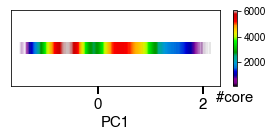

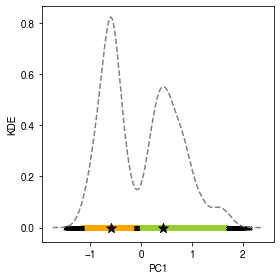

In [7]:
pca_headers = ["PC%i"%(x + 1) for x in range(n_pca)]
#plot_clusters(clone_apo, red_dim_coords_tot[0:index_apo_end,0].reshape(-1, 1), output_folder+'/apo_1',pca_headers[:2] ) 
#plot_clusters(clone_holo, red_dim_coords_tot[index_apo_end:index_tot_end,0].reshape(-1, 1), output_folder+'/holo_1',pca_headers[:2] )
plot_clusters(clone_apoholo, red_dim_coords_tot[:,0].reshape(-1, 1), output_folder+'/'+tot_name+'_1',pca_headers[:2] )

# Save clusters

In [4]:
# Load trajectories
struct_apo = mdtraj.load(trj_apo, top=topo_apo)
struct_holo = mdtraj.load(trj_holo, top=topo_apo)
struct_apoholo = mdtraj.load(trj_tot, top=topo_apo)

In [10]:
unique_labels = range(len(clone_apoholo.centers)) 
folder = output_folder+'/'+tot_name+'_1'

# Save center
[struct_apoholo[center].save(folder+"/Center_%d.pdb"%(center_id + 1)) for center, center_id in zip(clone_apoholo.centers, unique_labels)]
# Save trajs
[struct_apo[clone_apoholo.labels_[0:index_apo_end] == lab].save(folder+"/Cluster_apo_%d.xtc"%(lab + 1)) for lab in unique_labels]
[struct_holo[clone_apoholo.labels_[index_apo_end:] == lab].save(folder+"/Cluster_holo_%d.xtc"%(lab + 1)) for lab in unique_labels]

[None, None]

# Save extreme structures

In [9]:
minframe=[100,-1,-2]
maxframe=[-100,-1,-2]
for frame in zip(red_dim_coords_tot[:,0].reshape(-1, 1), clone_apoholo.labels_, range(len(clone_apoholo.labels_))):
    if frame[1] != -1:
        if frame[0] < minframe[0]:
            minframe = frame
        if frame[0] > maxframe[0]:
            maxframe = frame

folder = output_folder+'/'+tot_name+'_1'
struct_apoholo[minframe[2]].save(folder+"/extremeleft.pdb")          
struct_apoholo[maxframe[2]].save(folder+"/extremeright.pdb")          


In [11]:
a = sorted(zip(red_dim_coords_tot[:,0].reshape(-1, 1), clone_apoholo.labels_, range(len(clone_apoholo.labels_))))
a = [el for el in a if el[1] != -1]
a[0]
struct_apoholo[a[0][2]].save(folder+"/extremeleft1.pdb")
struct_apoholo[a[1][2]].save(folder+"/extremeleft2.pdb")
struct_apoholo[a[2][2]].save(folder+"/extremeleft3.pdb")
struct_apoholo[a[3][2]].save(folder+"/extremeleft4.pdb")
struct_apoholo[a[4][2]].save(folder+"/extremeleft5.pdb")
struct_apoholo[a[5][2]].save(folder+"/extremeleft6.pdb")
struct_apoholo[a[6][2]].save(folder+"/extremeleft7.pdb")
struct_apoholo[a[7][2]].save(folder+"/extremeleft8.pdb")
struct_apoholo[a[8][2]].save(folder+"/extremeleft9.pdb")
struct_apoholo[a[9][2]].save(folder+"/extremeleft10.pdb")
struct_apoholo[a[10][2]].save(folder+"/extremeleft11.pdb")
struct_apoholo[a[11][2]].save(folder+"/extremeleft12.pdb")
struct_apoholo[a[12][2]].save(folder+"/extremeleft13.pdb")
struct_apoholo[a[13][2]].save(folder+"/extremeleft14.pdb")
struct_apoholo[a[14][2]].save(folder+"/extremeleft15.pdb")
struct_apoholo[a[15][2]].save(folder+"/extremeleft16.pdb")
struct_apoholo[a[16][2]].save(folder+"/extremeleft17.pdb")
struct_apoholo[a[17][2]].save(folder+"/extremeleft18.pdb")
struct_apoholo[a[18][2]].save(folder+"/extremeleft19.pdb")
struct_apoholo[a[19][2]].save(folder+"/extremeleft20.pdb")

struct_apoholo[a[-1][2]].save(folder+"/extremeright1.pdb")
struct_apoholo[a[-2][2]].save(folder+"/extremeright2.pdb")
struct_apoholo[a[-3][2]].save(folder+"/extremeright3.pdb")
struct_apoholo[a[-4][2]].save(folder+"/extremeright4.pdb") 
struct_apoholo[a[-5][2]].save(folder+"/extremeright5.pdb")
struct_apoholo[a[-6][2]].save(folder+"/extremeright6.pdb")
struct_apoholo[a[-7][2]].save(folder+"/extremeright7.pdb")
struct_apoholo[a[-8][2]].save(folder+"/extremeright8.pdb")
struct_apoholo[a[-9][2]].save(folder+"/extremeright9.pdb")
struct_apoholo[a[-10][2]].save(folder+"/extremeright10.pdb")
struct_apoholo[a[-11][2]].save(folder+"/extremeright11.pdb")
struct_apoholo[a[-12][2]].save(folder+"/extremeright12.pdb")
struct_apoholo[a[-13][2]].save(folder+"/extremeright13.pdb")
struct_apoholo[a[-14][2]].save(folder+"/extremeright14.pdb") 
struct_apoholo[a[-15][2]].save(folder+"/extremeright15.pdb")
struct_apoholo[a[-16][2]].save(folder+"/extremeright16.pdb")
struct_apoholo[a[-17][2]].save(folder+"/extremeright17.pdb")
struct_apoholo[a[-18][2]].save(folder+"/extremeright18.pdb")
struct_apoholo[a[-19][2]].save(folder+"/extremeright19.pdb")
struct_apoholo[a[-20][2]].save(folder+"/extremeright20.pdb")

In [56]:
a[-1]

(array([1.7153147], dtype=float32), 0, 13395)

 # Save  PC in B-fact

In [6]:
folder = output_folder
save_pc_bfact(63,165,22,struct_apo, pca_apo.components_[0],folder+"/IMAGES/ttpa_apo_pc0.pdb")
save_pc_bfact(63,165,22,struct_apo, pca_holo.components_[0],folder+"/IMAGES/ttpa_holo_pc0.pdb")
save_pc_bfact(63,165,22,struct_apo, pca_tot.components_[0],folder+"/IMAGES/ttpa_apoholo_pc0.pdb")

# HISTOGRAM FOR MAIN FIGURE

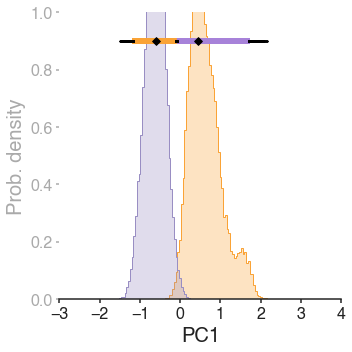

In [ ]:
from itertools import islice, cycle
import statsmodels.api as sm
import matplotlib.cm as cm

def plot_clusters_formainfig(clone, data, path, headers=None):
    color_list = np.array(['#a782d9','#faa336','#ff7295' ])
    colors = np.array(list(islice(cycle(color_list),len(clone.centers))))
    
    fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

    min_pc = -3
    max_pc = 4

    sns.despine(left=True)
    ax.set_xlim([min_pc,max_pc])
    ax.set_ylim([0,1])

    ax.set_xticks([-3,-2,-1,0,1,2,3,4])
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax.set_xlabel("PC1", fontsize=20, labelpad=5)
    ax.set_ylabel("Prob. density", fontsize=20)
    
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)
    # increase tick width
    axcolor = '#222222'
    axcolor2 = '#AAAAAA'
    ax.tick_params(width=1.5)
    ax.xaxis.label.set_color(axcolor)        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color(axcolor2)          #setting up Y-axis label color to blue
    ax.tick_params(axis='x', colors=axcolor)    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors=axcolor2)    #setting up X-axis tick color to red

    ax.spines['left'].set_color(axcolor2)        # setting up Y-axis tick color to red
    ax.spines['bottom'].set_color(axcolor)  
    
    centers = np.array(clone.centers)
    labels = np.array(clone.labels_)
    labels_all = np.array(clone.labels_all)
    core = clone.core_card
    rho = clone.rho

    ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True)
    ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.3, density=True)

    ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True)
    ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.3, density=True)
    
    # Mask for plotting
    assigned_mask = np.where(labels != -1)
    outliers_mask = np.where(labels == -1)

    # Sort some values for better visualization after
    arcore = np.argsort(core)
    s_cores = core[arcore]
    s_x = data[arcore]

    ypos=[0.9]
    # Plot clusters
    ax.scatter(data[assigned_mask, 0], ypos * len(data[assigned_mask]), marker='|', color=colors[labels[assigned_mask]], zorder=1, clip_on=False)
    ax.scatter(data[outliers_mask, 0], ypos * len(data[outliers_mask]), marker='D', s=2, color='black', zorder=1, clip_on=False)
    ax.scatter(data[centers, 0], ypos * len(data[centers]), marker='D', s=30, color='black', zorder=1, clip_on=False)

    fig.tight_layout()
    fig.savefig(output_folder+'/IMAGES/histograms_pc_clustering_mainfig.pdf', dpi=600)
    plt.show()

plot_clusters_formainfig(clone_apoholo, red_dim_coords_tot[:,0].reshape(-1, 1), output_folder+'/'+tot_name+'_1',pca_headers[:2] )

0 98.66566048091106 1.3343395190889447 49.57824563790347 48.916703513485935 0.6615421244175369
1 0.6696428571428571 99.33733258928571 48.76024625012755 0.32651950613924696 48.43712798884392
-1 45.64102564102564 54.35897435897436 1.6581068671133636 0.7567769803748172 0.9013298867385463


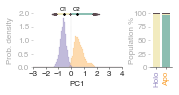

In [11]:
clusters = np.unique(clone_apoholo.labels_)
labels_apo = clone_apoholo.labels_[0:index_apo_end]
labels_holo = clone_apoholo.labels_[index_apo_end:index_tot_end]
pop_list = []
for label in [0,1,-1]:
    count_apo = np.count_nonzero(labels_apo == label)
    count_holo = np.count_nonzero(labels_holo == label)
    count_tot= np.count_nonzero(clone_apoholo.labels_[0:58800] == label)
    pop_list.append([label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100, count_apo/count_tot*100*count_tot/len(clone_apoholo.labels_), count_holo/count_tot*100*count_tot/len(clone_apoholo.labels_)])
    print(label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100,count_apo/count_tot*100*count_tot/len(clone_apoholo.labels_),count_holo/count_tot*100*count_tot/len(clone_apoholo.labels_) )

df = pd.DataFrame(pop_list, columns=['cluster', 'frames apo (%)', 'frames holo (%)', 'cluster relevance (%)', 'weighted_cluster_relevance_apo','weighted_cluster_relevance_holo', ])  

df.to_csv(output_folder+'/'+tot_name+"_1/population_analysis.txt", sep=" ", float_format="%2.2f")


from itertools import islice, cycle
import statsmodels.api as sm
import matplotlib.cm as cm
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(2.5,1), )
plt.subplots_adjust(wspace=0.5)
color_list = np.array(['#8CBEB2','#F2EBBF','#f49090', "#5C4B51"])
colors = np.array(list(islice(cycle(color_list),len(clone_apoholo.centers))))
min_pc = -3
max_pc = 4
axcolor = '#222222'
axcolor2 = '#AAAAAA'
hfont = {'fontname':'Helvetica'}


centers = np.array(clone_apoholo.centers)
labels = np.array(clone_apoholo.labels_)
labels_all = np.array(clone_apoholo.labels_all)
core = clone_apoholo.core_card

sns.despine(left=True)
#PLOT 1 
ax1.set_xlim([min_pc,max_pc])
ax1.set_ylim([0,2])
ax1.set_xticks([-3,-2,-1,0,1,2,3,4])
ax1.set_yticks([0,0.5,1.0,1.5, 2])
ax1.set_xlabel("PC1", fontsize=8, labelpad=3)
ax1.set_ylabel("Prob. density", fontsize=8)

ax1.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1.5, length=2)
ax1.tick_params(width=0.5)
# change all spines
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.5)
# axes colors
ax1.xaxis.label.set_color(axcolor)
ax1.yaxis.label.set_color(axcolor2)         
ax1.tick_params(axis='x', colors=axcolor)    
ax1.tick_params(axis='y', colors=axcolor2)  
ax1.spines['left'].set_color(axcolor2)
ax1.spines['bottom'].set_color(axcolor)  
    
ax1.hist(red_dim_coords_tot[0:index_apo_end,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True, linewidth=0.2,  alpha=0.5)
ax1.hist(red_dim_coords_tot[0:index_apo_end,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.4, density=True, linewidth=0.2)
ax1.hist(red_dim_coords_tot[index_apo_end:index_tot_end:2,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True, linewidth=0.2)
ax1.hist(red_dim_coords_tot[index_apo_end:index_tot_end:2,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.6, density=True, linewidth=0.2)
    
# Mask for plotting
assigned_mask = np.where(labels != -1)
outliers_mask = np.where(labels == -1)

# Sort some values for better visualization after
data = red_dim_coords_tot[:,0].reshape(-1, 1)
arcore = np.argsort(core)
s_cores = core[arcore]
s_x = data[arcore]

ypos=[1.97]
# Plot clusters
ax1.axvline(x=-0.05, color='#AAAAAA', linestyle='--', ymax=ypos[0], linewidth=0.2, zorder=-1)
ax1.scatter(data[assigned_mask, 0], ypos * len(data[assigned_mask]), marker='|', s=3, color=colors[labels[assigned_mask]], zorder=1, clip_on=False)
ax1.scatter(data[outliers_mask, 0], ypos * len(data[outliers_mask]), marker='D', s=0.05, color=color_list[3], zorder=1, clip_on=False)
ax1.scatter(data[centers, 0], ypos * len(data[centers]), marker='D', s=2, color='black', zorder=1, clip_on=False)

ax1.text(-0.9,2.08, "C1", fontsize=6)
ax1.text(0.1,2.08, "C2", fontsize=6)

    
    
#PLOT 2 
ax2.set_ylim([0,50])
ax2.set_yticks([0,12.5,25,37.5,50])
ax2.set_yticklabels([0,25,50,75,100])

ax2.set_xticks([0,1])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1, length=2)
ax2.set_ylabel("Population %", fontsize=8, labelpad=-2, **hfont)
    
# set colors 
ax2.tick_params(width=0.5)
ax2.xaxis.label.set_color(axcolor)       
ax2.yaxis.label.set_color(axcolor2)          
ax2.tick_params(axis='x', colors=axcolor) 
ax2.tick_params(axis='y', colors=axcolor2)
ax2.spines['left'].set_color(axcolor2)        
ax2.spines['bottom'].set_color(axcolor)  
# change all spines
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(0.5)


new_df = df[['weighted_cluster_relevance_apo','weighted_cluster_relevance_holo', ]]
new_df.reindex([1,0,2]).transpose().plot(kind='bar', legend=False, width=0.8, ax=ax2, color=[color_list[0], color_list[1], color_list[3]], stacked=True)

ax2.set_xticklabels(["Holo", "Apo"], rotation = 90, ha='center',**hfont, fontsize=8)
ax2.get_xticklabels()[0].set_color("#998EC3")
ax2.get_xticklabels()[1].set_color("#FAA336")

#fig.tight_layout()
fig.savefig(output_folder+'/IMAGES/total_figure.png', dpi=1200, bbox_inches='tight')


(5881,)
(5881,)


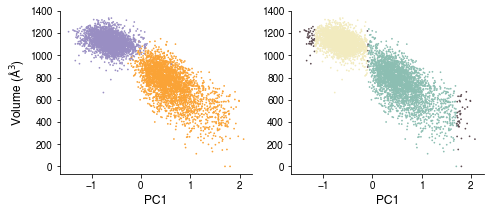

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(7.6,3), )

sns.despine()
vol = np.loadtxt('pocket/mdpout_descriptors.txt', skiprows=1, unpack=True)
lab = clone_apoholo.labels_[::10]
print(np.shape(vol[0]))
print(np.shape(lab))
#plt.scatter(lab, vol[1], s=0.01)
colorlist= ['#8CBEB2','#F2EBBF','#6C9AC4', "#5C4B51"]
lab = [colorlist[0] if x==0 else x for x in lab]
lab = [colorlist[1] if x==1 else x for x in lab]
lab = [colorlist[2] if x==2 else x for x in lab]
lab = [colorlist[-1] if x==-1 else x for x in lab]
#lab
ax1.set_xlabel('PC1', fontsize=12)
ax2.set_xlabel('PC1', fontsize=12)
ax1.set_ylabel('Volume (\u212b$^3$)', fontsize=12)

ax1.scatter(red_dim_coords_tot[::10,0], vol[1], s=0.5, c=['#FAA336']*2940+['#998EC3']*2941)
ax2.scatter(red_dim_coords_tot[::10,0], vol[1], s=0.5, c=lab)

fig.savefig(output_folder+'/IMAGES/volume.png', dpi=600, bbox_inches='tight')


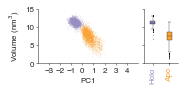

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(2.5,1),sharey=True)
plt.subplots_adjust(wspace=0.1)
color_list = np.array(['#8CBEB2','#F2EBBF','#6C9AC4', "#5C4B51"])
colors = np.array(list(islice(cycle(color_list),len(clone_apoholo.centers))))
min_pc = -3
max_pc = 4
axcolor = '#222222'
axcolor2 = '#AAAAAA'
hfont = {'fontname':'Helvetica'}


sns.despine(left=False)
#PLOT 1 
ax1.set_xlim([-4,5])
ax1.set_ylim([0,1500])
ax1.set_xticks([-3,-2,-1,0,1,2,3,4])
ax1.set_yticks([0,500,1000,1500])
ax1.set_yticklabels([0,5,10,15])

ax1.set_xlabel("PC1", fontsize=8, labelpad=3)
ax1.set_ylabel('Volume (nm$^3$)', fontsize=8)

ax1.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1.5, length=2)
ax1.tick_params(width=0.5)
# change all spines
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.5)
# axes colors
ax1.xaxis.label.set_color(axcolor)
ax1.yaxis.label.set_color(axcolor)         
ax1.tick_params(axis='x', colors=axcolor)    
ax1.tick_params(axis='y', colors=axcolor)  
ax1.spines['left'].set_color(axcolor)
ax1.spines['bottom'].set_color(axcolor)  
    
colorlist= ['#8CBEB2','#F2EBBF','#6C9AC4', "#5C4B51"]

ax1.scatter(red_dim_coords_tot[::10,0], vol[1], c=['#FAA336']*2941+['#998EC3']*2940, marker='o', s=0.2, linestyle='None',edgecolors=None, linewidths=0 )
    
    
#PLOT 2 
#ax2.set_ylim([0,50])
#ax2.set_yticks([])
#ax2.set_yticklabels([0,25,50,75,100])
#ax2.set_xticks([0,1])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1, length=2)
#ax2.set_xlabel("Clusters", fontsize=20, labelpad=5)
#ax2.set_ylabel("Population %", fontsize=8, labelpad=-2, **hfont)
    
# set colors 
ax2.tick_params(width=0.5)
ax2.xaxis.label.set_color(axcolor)       
ax2.yaxis.label.set_color(axcolor)          
ax2.tick_params(axis='x', colors=axcolor) 
ax2.tick_params(axis='y', colors=axcolor)
ax2.spines['left'].set_color(axcolor)        
ax2.spines['bottom'].set_color(axcolor)  
# change all spines
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(0.5)


ax2.set_xticklabels(["Holo", "Apo"], rotation = 90, ha='center',**hfont, fontsize=8)
ax2.get_xticklabels()[0].set_color("#998EC3")
ax2.get_xticklabels()[1].set_color("#FAA336")


vol = np.loadtxt('pocket/mdpout_descriptors.txt', skiprows=1, unpack=True)
color = dict(boxes='black', whiskers='black', medians='red', caps='black')
data=[vol[1,2941:],vol[1,0:2941]]

boxprops = dict(linestyle='-', linewidth=0.3, color='black')
flierprops = dict(marker='o', markerfacecolor='black', linewidth=0.2, markersize=0.5, fillstyle='full', markeredgewidth=0.0)
medianprops = dict(linestyle='-', linewidth=0.3, color='black')
#meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
#meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
whiskerprops = dict(linestyle='-',linewidth=0.3, color='black')
capprops = dict(linewidth=0.3, color='black')


bp = ax2.boxplot(data, widths=0.3,patch_artist=True,
            flierprops=flierprops, 
            whiskerprops = whiskerprops,
            boxprops=boxprops,
            medianprops=medianprops,
            capprops=capprops)

colors=['#998EC3','#FAA336']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

fig.savefig(output_folder+'/IMAGES/volume_figure.png', dpi=600, bbox_inches='tight')